## get glm coefficients and correlations for publication
Update data in pipeline if needed.

In [1]:
import numpy as np
import pandas as pd
from glob import glob
from subprocess import check_output

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Get data

In [2]:
with open('../forecast_pipeline/pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [3]:
data_fname = glob('../forecast_pipeline/pipeline_data/data_????-??-??.csv')[0]
date = data_fname.split('/')[-1][:-4].split('_')[1]

result_folder = 'results_perturbation_75rand'
num_runs = 20
frac=.75

data_fname_glm_prefix = data_fname.split('/')[-1][:-4] + '_glm'

In [4]:
df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())

### Covariates

In [5]:
covariates_baseline = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
]
covariates_full = covariates_baseline + ['risk_flu', 'urban_risk']

### standarize

In [6]:
df_z = df[steps_].copy()
for c in covariates_full:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,case0,case1,case2,case3,case4,case5,case6,case7,case8,case9,...,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12.0,7.0,6.0,11.0,9.0,23.0,42.0,45.0,61.0,43.0,...,-0.149053,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,1.006875,0.666999
01003,29.0,37.0,43.0,38.0,34.0,35.0,38.0,19.0,10.0,21.0,...,0.349320,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.296454,0.817850
01005,2.0,7.0,9.0,14.0,11.0,15.0,21.0,26.0,45.0,40.0,...,-0.241908,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.420657,-0.240836
01007,4.0,9.0,13.0,8.0,8.0,3.0,5.0,8.0,14.0,5.0,...,-0.248733,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.436170,-0.249735
01009,10.0,2.0,8.0,11.0,9.0,4.0,1.0,4.0,12.0,9.0,...,-0.143225,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.617627,-0.724261


## Functions

In [7]:
def glm(df, targets, cov, verbose=False):
    
    """
    """
    
    cors_cur, cors_nxt, r2_cur, r2_nxt, coef_dfs = [], [], [], [], []
    
    for i in range(len(targets)):
        cur = targets[i]
        formula = f'{cur}~{cov}'

        model = smf.glm(
            formula=formula,
            data=df,
            family=sm.families.Poisson(sm.families.links.log())
        ).fit()
        
        if verbose:
            print(f'{model.summary()}\n\n')

        prd = model.predict()
        cor_cur = pd.DataFrame(
            data={'prd': prd, 'grd': df[cur].values}, 
            index=df.index).corr().loc['prd', 'grd']
        cors_cur.append(cor_cur)
        r2_cur.append(r2_score(prd, df[cur].values))

        if i < len(targets) - 1:
            nxt = targets[i + 1]
            cor_nxt = pd.DataFrame(
                data={'prd': prd, 'grd': df[nxt].values}, 
                index=df.index).corr().loc['prd', 'grd']
            cors_nxt.append(cor_nxt)
            r2_nxt.append(r2_score(prd, df[nxt].values))

        # Get and save coefficients
        results_as_html = model.summary().tables[1].as_html()
        summary = pd.read_html(results_as_html, header=0, index_col=0)[0] 
        coef_dfs.append(summary[['coef']].rename(columns={'coef': cur}))
    
    cor_df = pd.concat([
        pd.DataFrame(data={'cor_cur': cors_cur}, index=steps),
        pd.DataFrame(data={'cor_nxt': cors_nxt}, index=steps[:-1])
    ], axis=1, join='outer')
    
    r2_df = pd.concat([
        pd.DataFrame(data={'r2_cur': r2_cur}, index=steps),
        pd.DataFrame(data={'r2_nxt': r2_nxt}, index=steps[:-1])
    ], axis=1, join='outer')
    
    coef_df = pd.concat(coef_dfs, axis=1).rename(columns={t: s for t, s in zip(targets, steps)}).T
    coef_df.index.name = 'date'
    
    return cor_df, r2_df, coef_df

# Full GLM

In [8]:
df_full = df_z.copy()
cov_full = '+'.join(covariates_full)

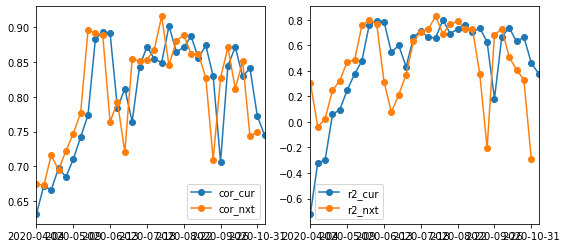

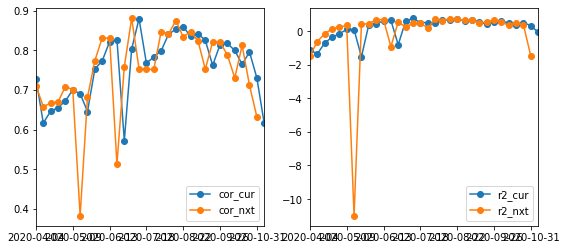

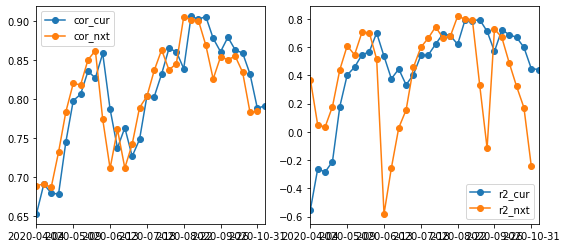

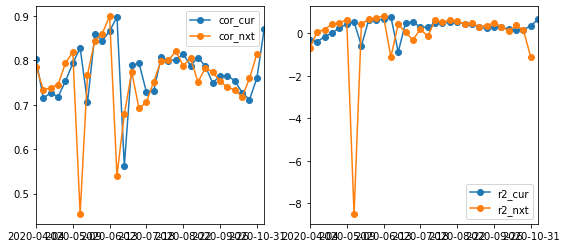

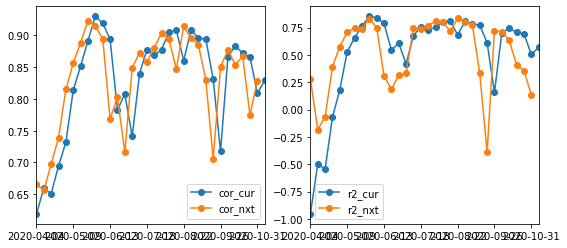

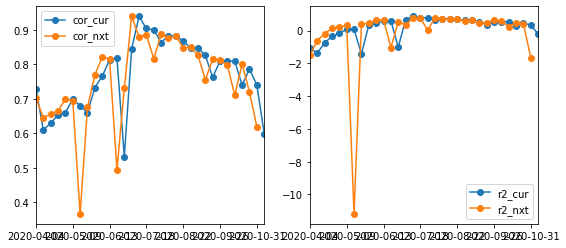

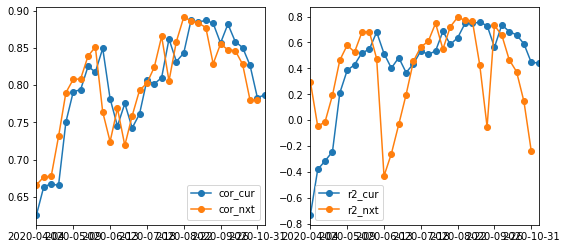

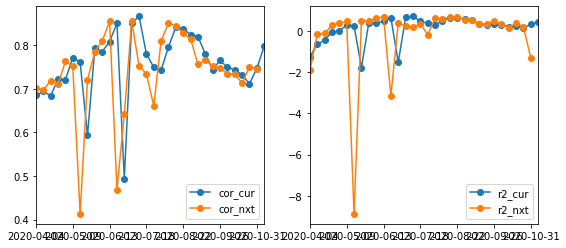

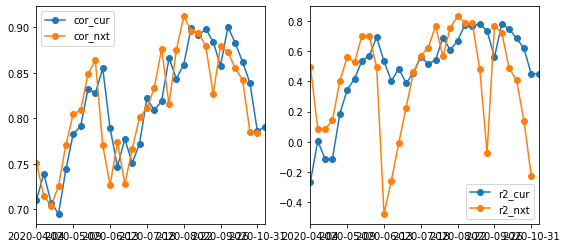

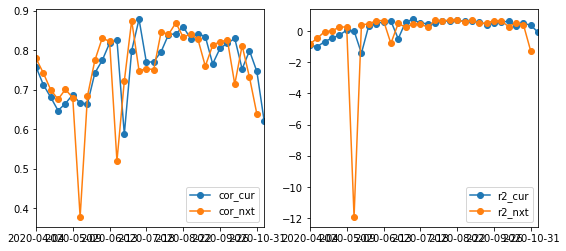

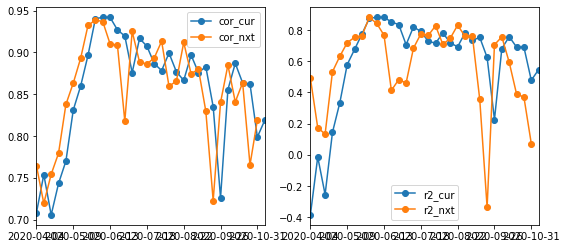

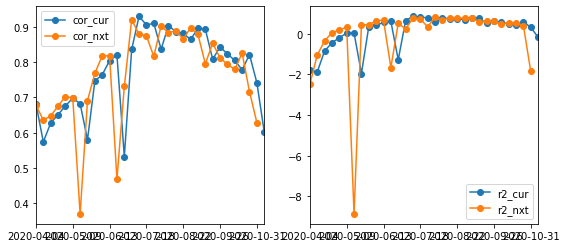

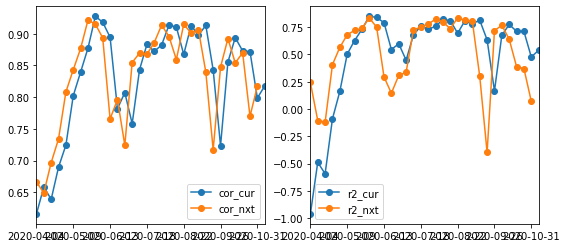

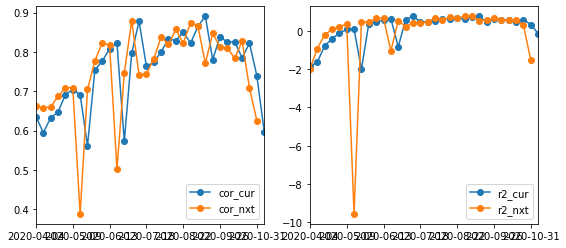

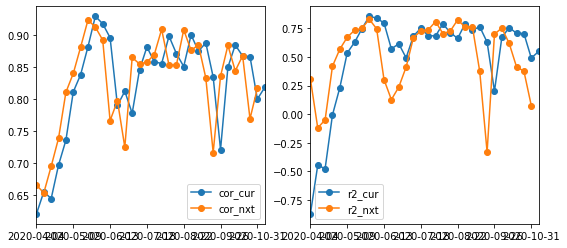

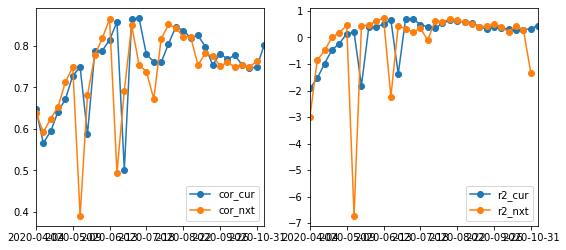

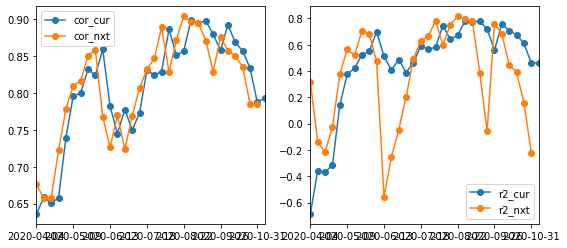

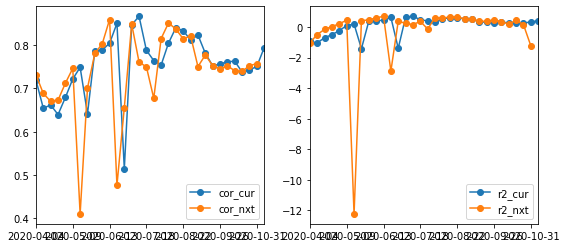

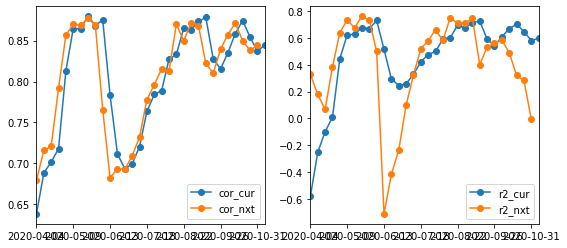

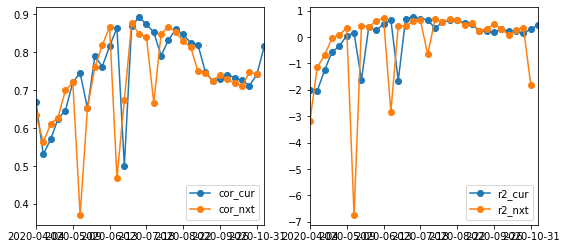

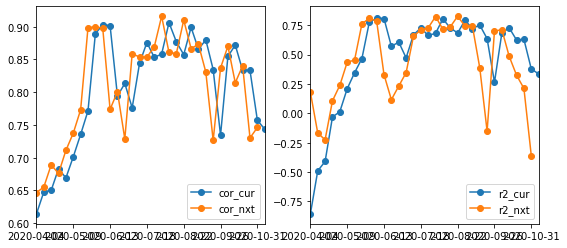

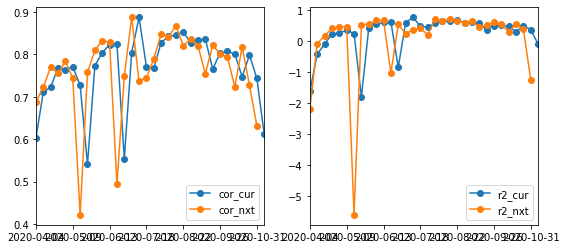

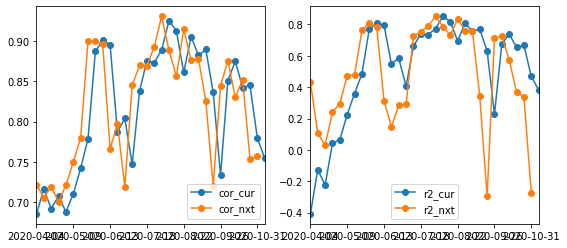

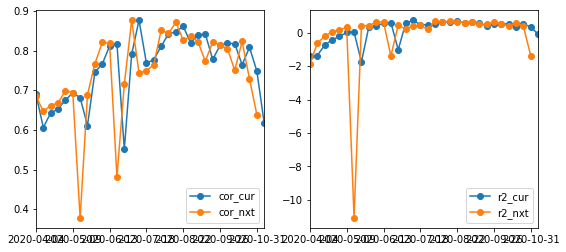

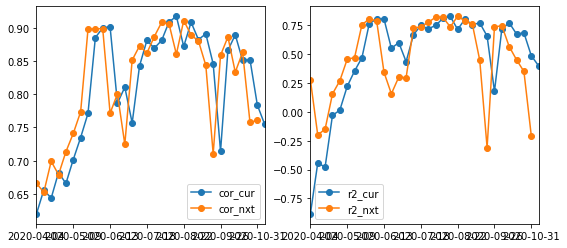

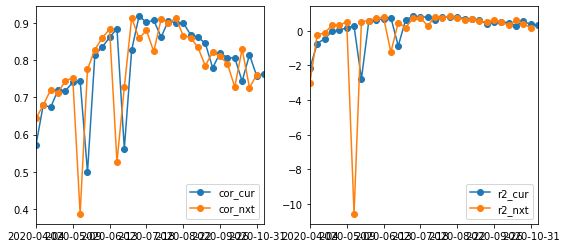

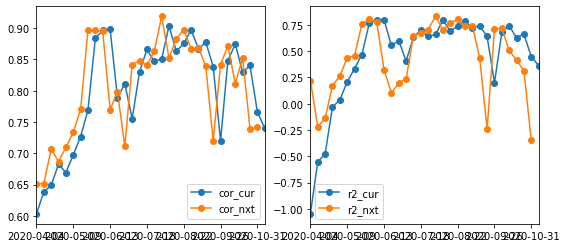

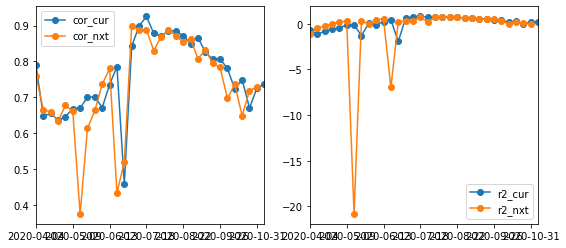

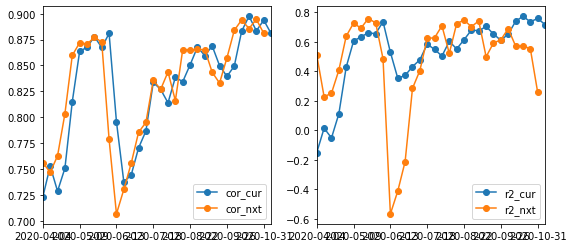

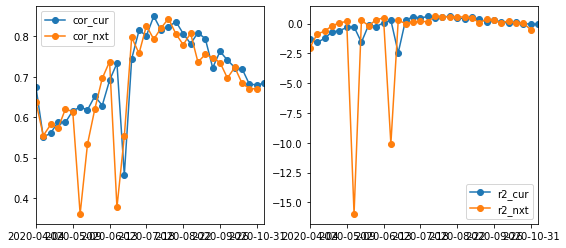

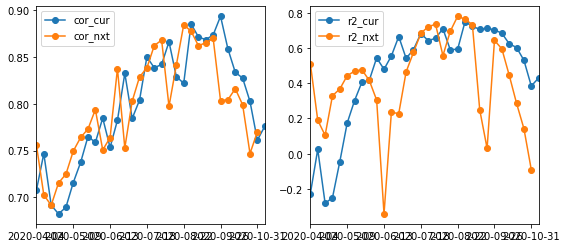

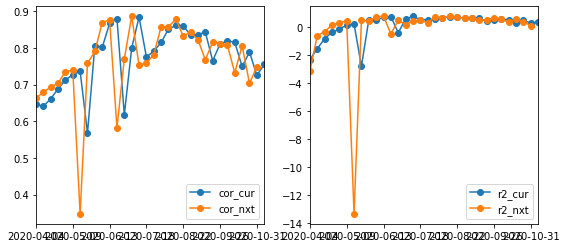

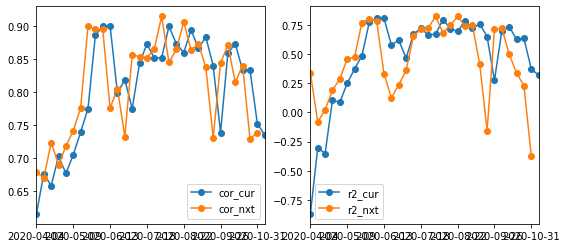

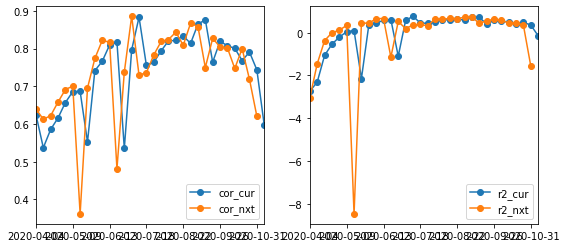

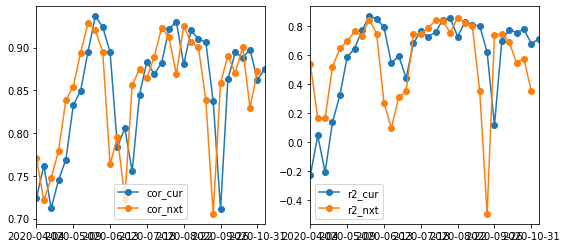

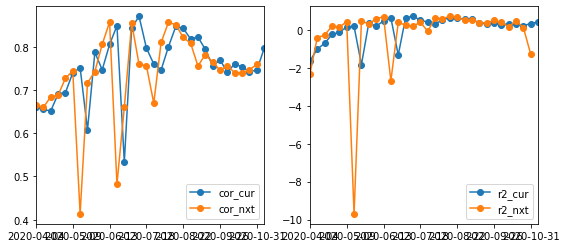

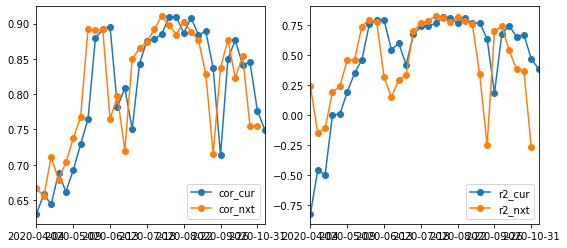

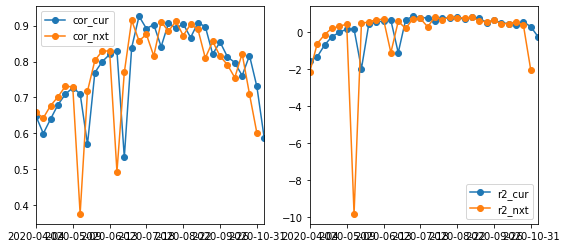

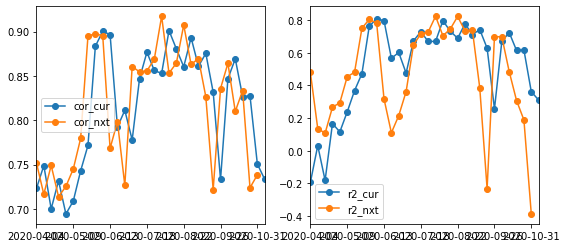

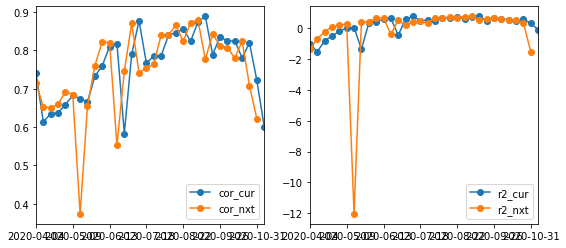

In [9]:
for r in range(num_runs):
    for targets, target_type in zip([steps_c, steps_d], ['case', 'death']):

        cor_df, r2_df, coef_df = glm(df_full.sample(frac=frac), targets, cov_full)

        fig, axes = plt.subplots(1, 2, figsize=(9, 4))
        cor_df.plot(ax=axes[0], marker='o')
        axes[0].legend()
        r2_df.plot(ax=axes[1], marker='o')
        axes[1].legend()

        coef_df.to_csv(f'{result_folder}/{target_type}/{date}_coef_full_{r}.csv', float_format='%.5f')
        cor_df.to_csv(f'{result_folder}/{target_type}/{date}_cor_full_{r}.csv', float_format='%.5f')
        r2_df.to_csv(f'{result_folder}/{target_type}/{date}_r2_full_{r}.csv', float_format='%.5f')

    data_fname_glm_full = f'{result_folder}/{data_fname_glm_prefix}-full_{r}.csv'
    df_full.to_csv(data_fname_glm_full, float_format='%.2f')

## Baseline GLM

In [10]:
df_baseline = df_z.copy()
cov_baseline = '+'.join(covariates_baseline)

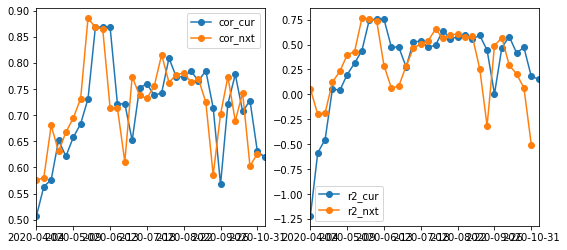

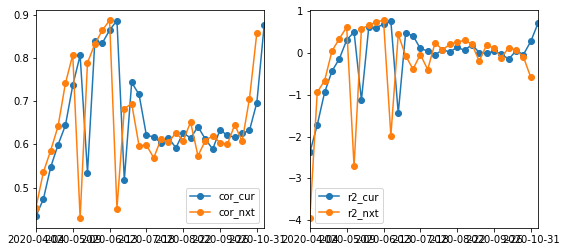

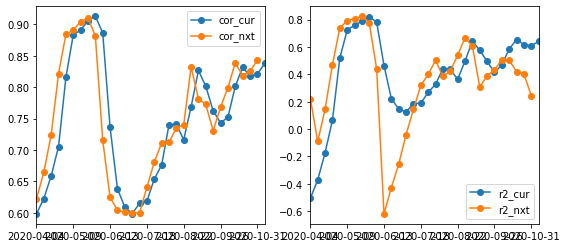

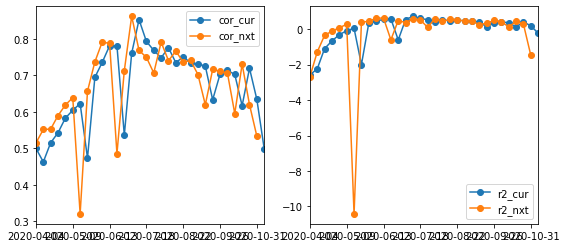

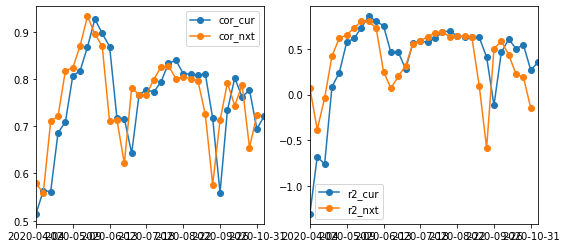

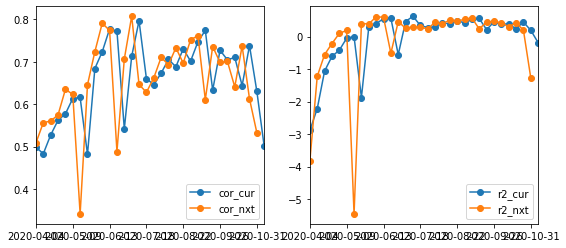

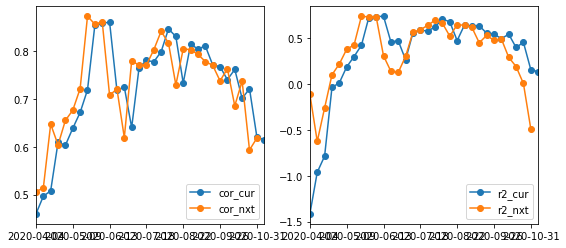

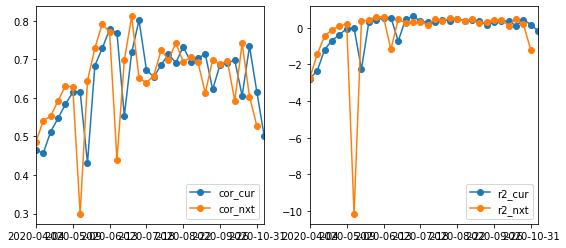

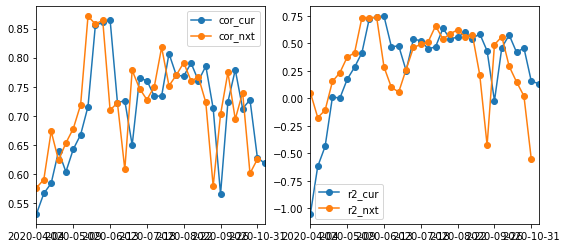

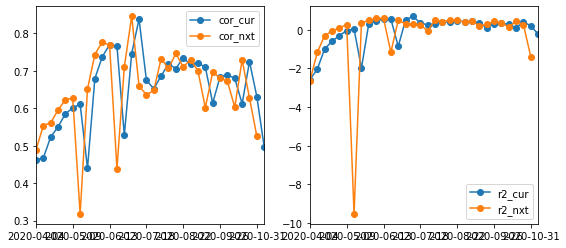

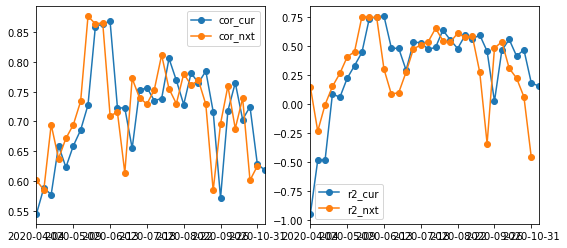

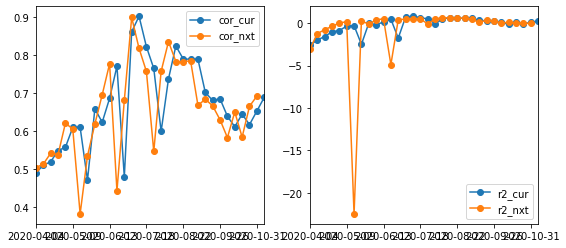

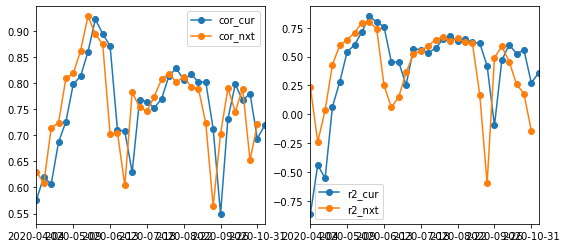

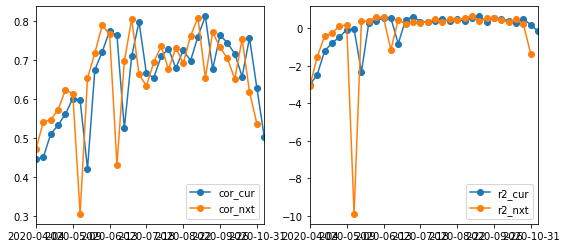

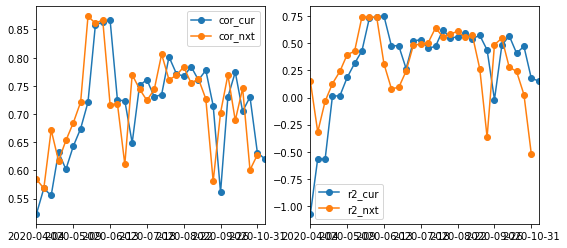

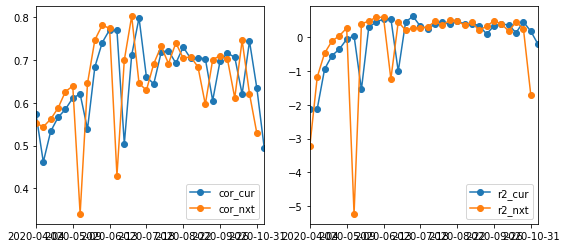

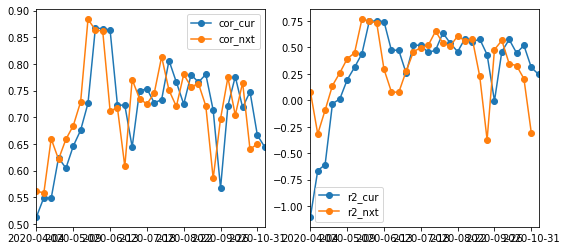

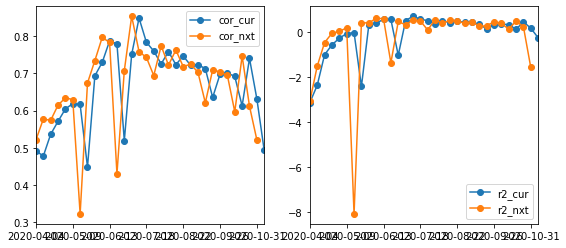

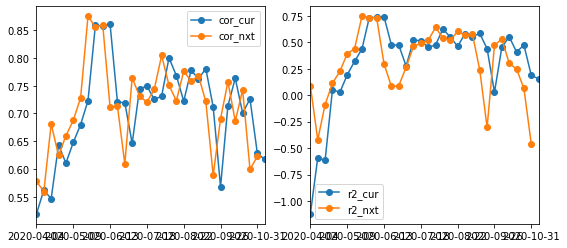

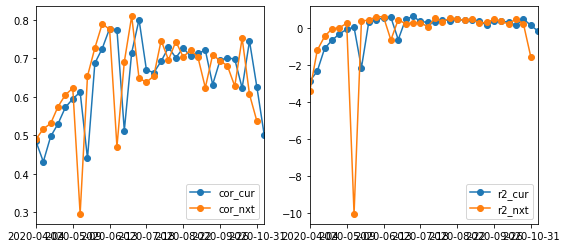

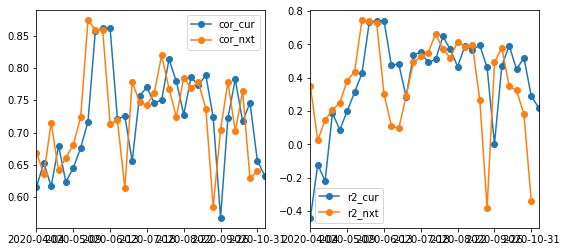

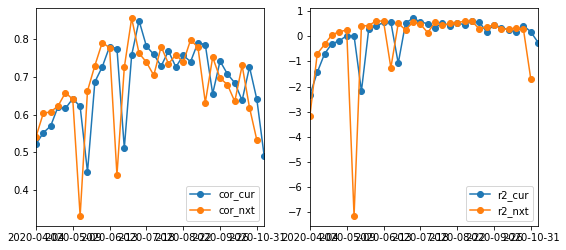

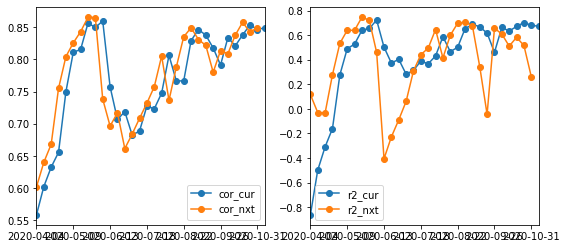

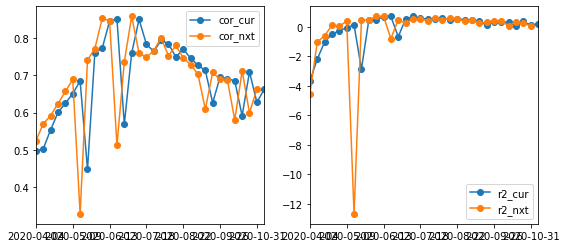

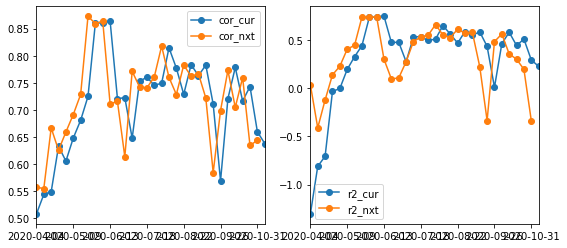

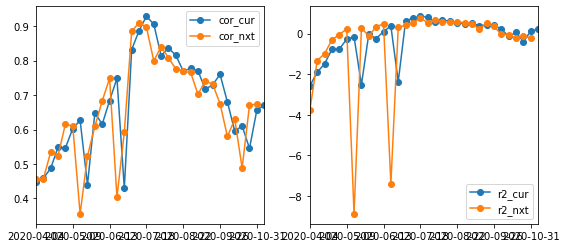

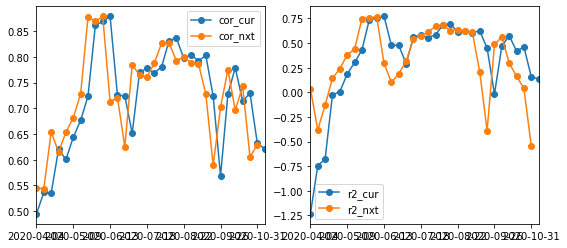

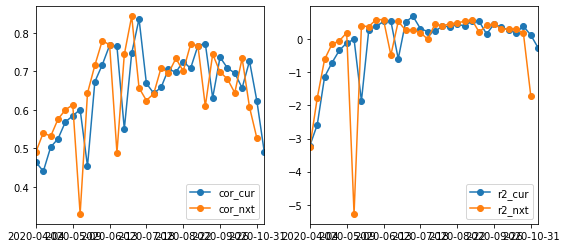

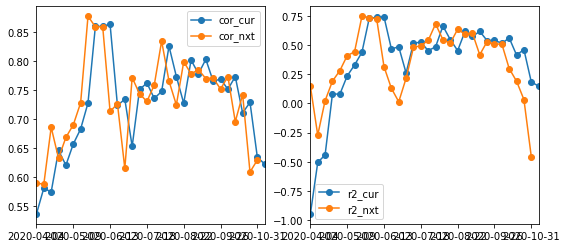

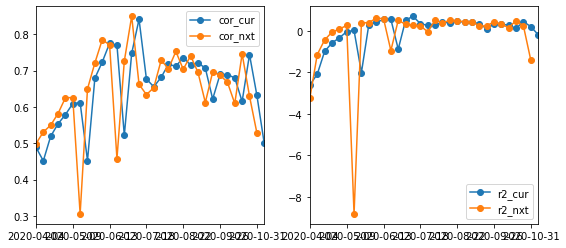

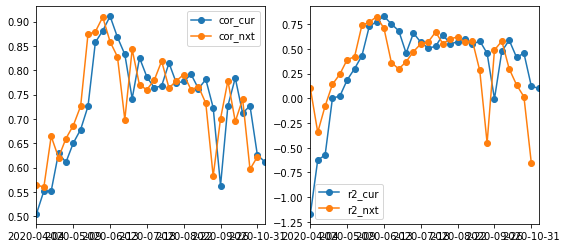

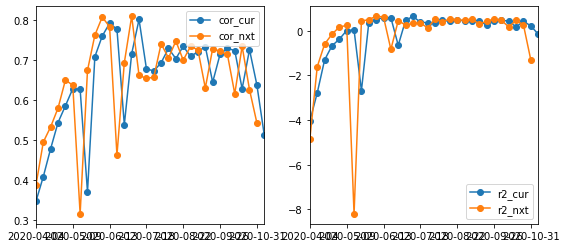

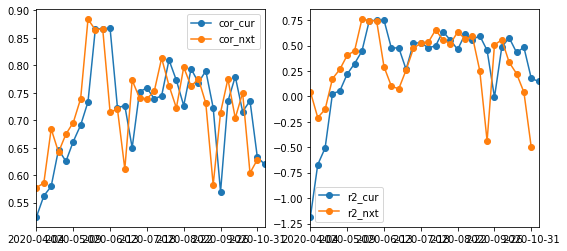

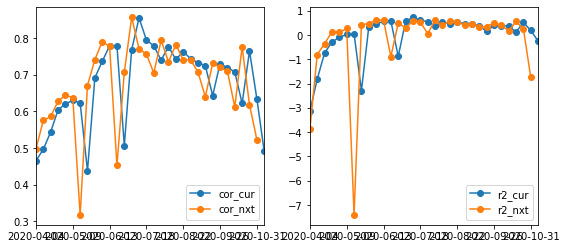

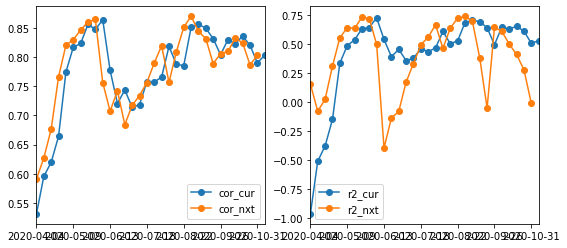

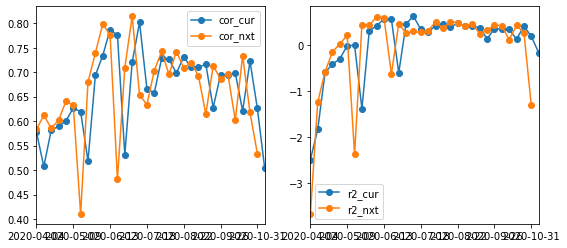

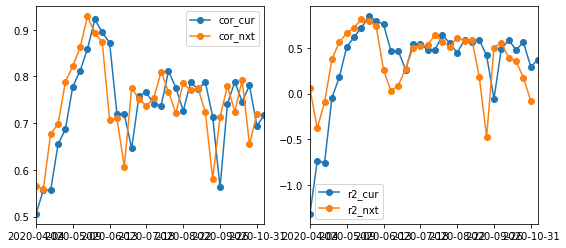

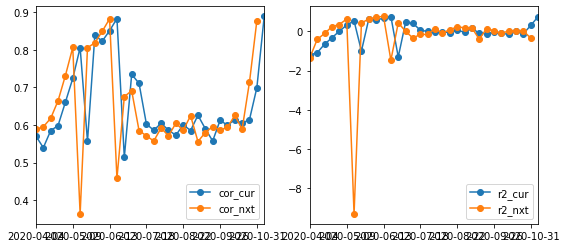

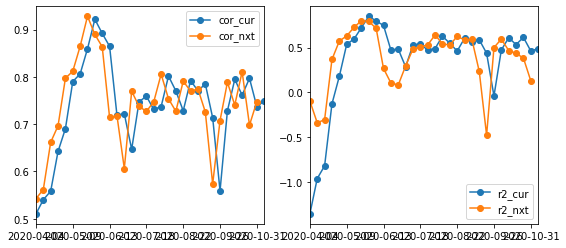

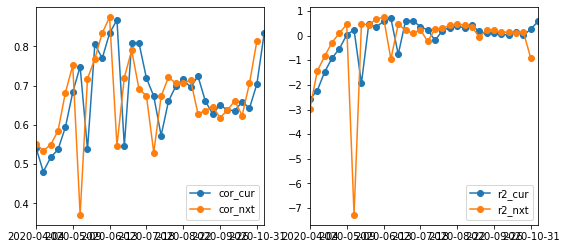

In [11]:
for r in range(num_runs):
    for targets, target_type in zip([steps_c, steps_d], ['case', 'death']):

        cor_df, r2_df, coef_df = glm(df_baseline.sample(frac=frac), targets, cov_baseline)

        fig, axes = plt.subplots(1, 2, figsize=(9, 4))
        cor_df.plot(ax=axes[0], marker='o')
        axes[0].legend()
        r2_df.plot(ax=axes[1], marker='o')
        axes[1].legend()

        coef_df.to_csv(f'{result_folder}/{target_type}/{date}_coef_baseline_{r}.csv', float_format='%.5f')
        cor_df.to_csv(f'{result_folder}/{target_type}/{date}_cor_baseline_{r}.csv', float_format='%.5f')
        r2_df.to_csv(f'{result_folder}/{target_type}/{date}_r2_baseline_{r}.csv', float_format='%.5f')

    data_fname_glm_baseline = f'{result_folder}/{data_fname_glm_prefix}-baseline_{r}.csv'
    df_baseline.to_csv(data_fname_glm_baseline, float_format='%.2f')

# Combine correlation of full and baseline

In [12]:
for target_type in ['case', 'death']:
    cor_dfs = []
    for r in range(num_runs):
        cor_full_fname = f'{result_folder}/{target_type}/{date}_cor_full_{r}.csv'
        cor_full = pd.read_csv(cor_full_fname, index_col=0)
        cor_full = cor_full.rename(columns={col: f'{col}_full_{r}' for col in cor_full.columns})

        cor_baseline_fname = f'{result_folder}/{target_type}/{date}_cor_baseline_{r}.csv'
        cor_baseline = pd.read_csv(cor_baseline_fname, index_col=0)
        cor_baseline = cor_baseline.rename(columns={col: f'{col}_baseline_{r}' for col in cor_baseline.columns})

        cor_dfs += [cor_full, cor_baseline]
    
    cor_df = pd.concat(cor_dfs, axis=1)    
    cor_df.index.name = 'date'
    cor_df.to_csv(f'{result_folder}/{target_type}/{date}_cor.csv', float_format='%.5f')
    
    # Get summary
    cor_summary = pd.DataFrame(index=cor_df.index)
    for s in ['cur', 'nxt']:
        for m in ['full', 'baseline']:
            cols = [f'cor_{s}_{m}_{i}' for i in range(num_runs)]
            cor_summary[f'cor_{s}_{m}_avg'] = cor_df[cols].mean(axis=1)
            cor_summary[f'cor_{s}_{m}_std'] = cor_df[cols].std(axis=1)
            cor_summary[f'cor_{s}_{m}_low'] = cor_summary[f'cor_{s}_{m}_avg'] - cor_summary[f'cor_{s}_{m}_std']
            cor_summary[f'cor_{s}_{m}_high'] = cor_summary[f'cor_{s}_{m}_avg'] + cor_summary[f'cor_{s}_{m}_std']
            
    cor_summary.to_csv(f'{result_folder}/{target_type}/{date}_cor_summary.csv', float_format='%.5f')

In [13]:
for target_type in ['case', 'death']:
    coef_dfs = []
    for r in range(num_runs):
        coef_full_fname = f'{result_folder}/{target_type}/{date}_coef_full_{r}.csv'
        coef_full = pd.read_csv(coef_full_fname, index_col=0)
        coef_full = coef_full.rename(columns={col: f'{col}_full_{r}' for col in coef_full.columns})

        coef_baseline_fname = f'{result_folder}/{target_type}/{date}_coef_baseline_{r}.csv'
        coef_baseline = pd.read_csv(coef_baseline_fname, index_col=0)
        coef_baseline = coef_baseline.rename(columns={col: f'{col}_baseline_{r}' for col in coef_baseline.columns})

        coef_dfs += [coef_full, coef_baseline]
    
    coef_df = pd.concat(coef_dfs, axis=1)    
    coef_df.index.name = 'date'
    coef_df.to_csv(f'{result_folder}/{target_type}/{date}_coef.csv', float_format='%.5f')
    
    # Get summary
    coef_summary = pd.DataFrame(index=coef_df.index)

    for m in ['full', 'baseline']:
        if m == 'full':
            covariates = covariates_full
        else:
            covariates = covariates_baseline
        
        for cov in covariates:
            cols = [f'{cov}_{m}_{i}' for i in range(num_runs)]
            coef_summary[f'{cov}_{m}_avg'] = coef_df[cols].mean(axis=1)
            coef_summary[f'{cov}_{m}_std'] = coef_df[cols].std(axis=1)
            coef_summary[f'{cov}_{m}_low'] = coef_summary[f'{cov}_{m}_avg'] - coef_summary[f'{cov}_{m}_std']
            coef_summary[f'{cov}_{m}_high'] = coef_summary[f'{cov}_{m}_avg'] + coef_summary[f'{cov}_{m}_std']
            
    coef_summary.to_csv(f'{result_folder}/{target_type}/{date}_coef_summary.csv', float_format='%.5f')

In [7]:
for target_type in ['case', 'death']:
    r2_dfs = []
    for r in range(num_runs):
        r2_full_fname = f'{result_folder}/{target_type}/{date}_r2_full_{r}.csv'
        r2_full = pd.read_csv(r2_full_fname, index_col=0)
        r2_full = r2_full.rename(columns={col: f'{col}_full_{r}' for col in r2_full.columns})
        # print(r2_full.columns)

        r2_baseline_fname = f'{result_folder}/{target_type}/{date}_r2_baseline_{r}.csv'
        r2_baseline = pd.read_csv(r2_baseline_fname, index_col=0)
        r2_baseline = r2_baseline.rename(columns={col: f'{col}_baseline_{r}' for col in r2_baseline.columns})
        # print(r2_baseline.columns)
        r2_baseline[f'diff_{r}'] = r2_full[f'r2_cur_full_{r}'] - r2_baseline[f'r2_cur_baseline_{r}']
        
        r2_dfs += [r2_full, r2_baseline]
        
    
    r2_df = pd.concat(r2_dfs, axis=1)    
    r2_df.index.name = 'date'
    r2_df.to_csv(f'{result_folder}/{target_type}/{date}_r2.csv', float_format='%.5f')
    
    # Get summary
    r2_summary = pd.DataFrame(index=r2_df.index)
    for s in ['cur', 'nxt']:
        for m in ['full', 'baseline']:
            cols = [f'r2_{s}_{m}_{i}' for i in range(num_runs)]
            r2_summary[f'r2_{s}_{m}_avg'] = r2_df[cols].mean(axis=1)
            r2_summary[f'r2_{s}_{m}_std'] = r2_df[cols].std(axis=1)
            r2_summary[f'r2_{s}_{m}_low'] = r2_summary[f'r2_{s}_{m}_avg'] - r2_summary[f'r2_{s}_{m}_std']
            r2_summary[f'r2_{s}_{m}_high'] = r2_summary[f'r2_{s}_{m}_avg'] + r2_summary[f'r2_{s}_{m}_std']
    
    r2_summary['r2_diff_avg'] = r2_df[[f'diff_{r}' for r in range(num_runs)]].mean(axis=1)
    r2_summary['r2_diff_std'] = r2_df[[f'diff_{r}' for r in range(num_runs)]].std(axis=1)
    r2_summary['r2_diff_low'] = r2_summary['r2_diff_avg'] - r2_summary['r2_diff_std']
    r2_summary['r2_diff_high'] = r2_summary['r2_diff_avg'] + r2_summary['r2_diff_std']
    
    r2_summary.to_csv(f'{result_folder}/{target_type}/{date}_r2_summary.csv', float_format='%.5f')